In [1]:

%load_ext autoreload
%autoreload 2
import os
import dask
import panel
import pandas as pd
import matplotlib.pyplot as plt
import nisardev as nisar
import grimpfunc as grimp
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
import glob
import shapely
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
panel.extension() 

In [2]:
#paths

centreline_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/flowlines/glacier0001_iter03.shp"
terminus_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/data/MEaSUREs_0781/collated/JakbobshavnIsbraeTerminus.shp"
velocity_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/data/MEaSUREs_0766/JakobshavnIsbraeVelocitySeriesNew.nc"
centreline_maqit_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/centreline1.csv"

#read in velocity 
velocity = xr.open_dataset(velocity_path)

#read in centreline + make sure coordinate system = EPSG:3413
centreline = gpd.read_file(centreline_path)
centreline = centreline.to_crs("EPSG:3413")

centreline_shape = centreline.geometry.iloc[0]

#read in terminus
terminus = gpd.read_file(terminus_path)
terminus = terminus.to_crs("EPSG:3413")

terminus = terminus.rename(columns={"SourceDate": "Date"}) #rename for simplicity
terminus["Date"] = pd.to_datetime(terminus["Date"]) #make sure it is in datetime 

In [3]:
print(centreline.crs)
print(terminus.crs)

EPSG:3413
EPSG:3413


In [4]:
#intersection 

def intersection(centreline, terminus_line):
    intersect = centreline.intersection(terminus_line)

    if intersect.is_empty:
        return None
    
    if intersect.geom_type == "MultiPoint": #if there is more than one intersect put the point closes to the centre of the terminus line
        return min(intersect.geoms, key = lambda p: p.distance(terminus_line.centroid))
    
    return intersect

In [5]:
pts = []

for i in range(len(terminus)):
    terminus_line = terminus.geometry.iloc[i]
    pt = intersection(centreline_shape, terminus_line)
    pts.append(pt)

terminus["intersect_points"] = pts

terminus.head()

,Image_ID,Image_Tile,Date,Quality_Fl,Glacier_ID,geometry,intersect_points
0,SEN1_NSIDC_0723_V2_20160201_20160212,S1A_090_009787,2016-02-03,0,3,"LINESTRING (-184523.658 -2277242.523, -184005....",POINT (-182041.25466858875 -2275501.966626903)
1,SEN1_NSIDC_0723_V2_20170201_20170206,S1B_090_004141,2017-02-03,1,3,"LINESTRING (-185836.057 -2276614.059, -185698....",None
2,SEN1_NSIDC_0723_V2_20190215_20190220,S1B_090_014991,2019-02-17,1,3,"LINESTRING (-185915.432 -2276582.309, -185957....",None
3,SEN1_NSIDC_0723_V2_20150101_20150112,S1A_090_004012,2015-01-03,0,3,"LINESTRING (-188606.112 -2265922.891, -188399....",POINT (-182302.33390831872 -2275255.0299488134)
4,SEN1_NSIDC_0723_V2_20150113_20150124,S1A_090_004187,2015-01-15,1,3,"LINESTRING (-188634.464 -2265910.404, -188629....",POINT (-182654.5811722098 -2274965.15839306)


In [6]:
none_vals = terminus["intersect_points"].isna().sum()
print(none_vals)

total = len(terminus["intersect_points"])
print(total)


111
357


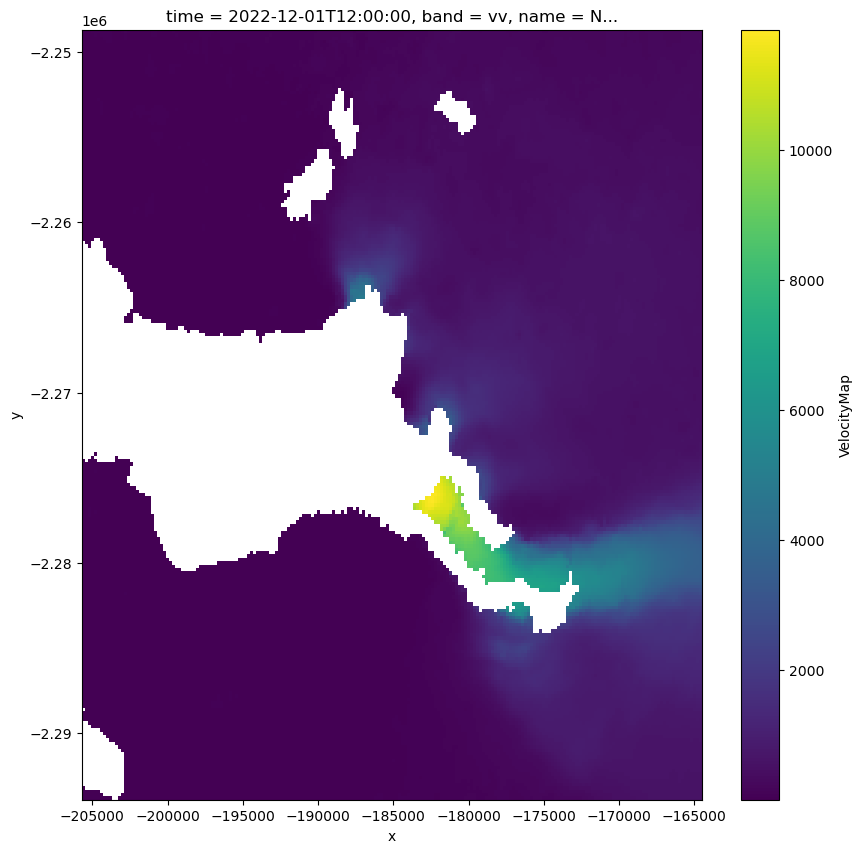

In [7]:

sampletime = 400 
vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime)

x_vals = velocity["x"].values
y_vals = velocity["y"].values

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)

fig, ax = plt.subplots(figsize=(10, 10))

vel_slice.plot(
    ax=ax,
    x="x",         
    y="y",         
    add_colorbar=True,
)

plt.show()

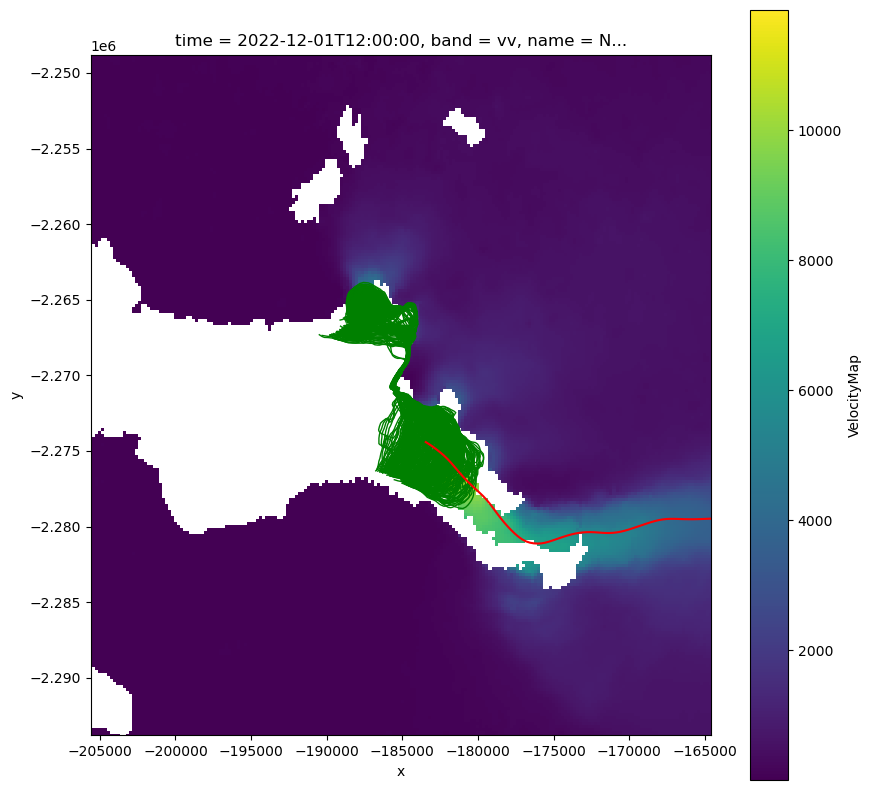

In [8]:

sampletime = 400
vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime)

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)

fig, ax = plt.subplots(figsize=(10, 10))


vel_slice.plot(
    ax=ax,
    x="x",         
    y="y",         
    add_colorbar=True,
)


terminus.plot(
    ax=ax,
    facecolor="none",
    edgecolor="green",
    linewidth=1,
)

centreline_gs = gpd.GeoSeries([centreline_shape], crs=terminus.crs if hasattr(terminus, "crs") else None)
centreline_gs.plot(
    ax=ax,
    color="red",
    linewidth=1.5,
)

ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(y_vals.min(), y_vals.max())
ax.set_aspect("equal")

plt.show()


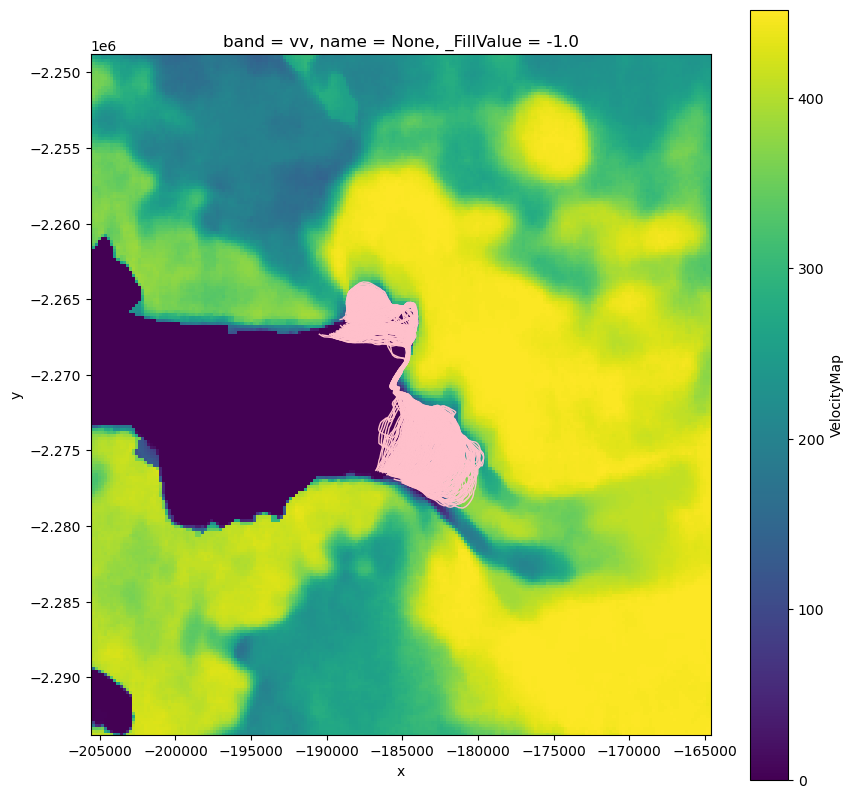

In [9]:

vel_band = velocity["VelocityMap"].isel(band=2)

valid_count = vel_band.count(dim="time") 

fig, ax = plt.subplots(figsize=(10, 10))

valid_count.plot(
    ax=ax,
    x="x",
    y="y",
    add_colorbar=True,
)

terminus.plot(
     ax=ax,
     facecolor="none",
     edgecolor="pink",
     linewidth=1,
)

ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(y_vals.min(), y_vals.max())
ax.set_aspect("equal")
plt.show()


In [10]:
#velocity at intersect points

vel_band = velocity["VelocityMap"].isel(band=2) 

velocity_at_intersections = []

for i in range(len(terminus)):
    pt = terminus["intersect_points"].iloc[i]
    
    if pt is None or pd.isna(pt):
        velocity_at_intersections.append(np.nan)
        continue
    
    v = vel_band.isel(time=i).sel(
        x=pt.x,
        y=pt.y,
        method="nearest"
    ).values
    
    velocity_at_intersections.append(float(v))

terminus["velocity_intersection"] = velocity_at_intersections

terminus.head()



,Image_ID,Image_Tile,Date,Quality_Fl,Glacier_ID,geometry,intersect_points,velocity_intersection
0,SEN1_NSIDC_0723_V2_20160201_20160212,S1A_090_009787,2016-02-03,0,3,"LINESTRING (-184523.658 -2277242.523, -184005....",POINT (-182041.25466858875 -2275501.966626903),NaN
1,SEN1_NSIDC_0723_V2_20170201_20170206,S1B_090_004141,2017-02-03,1,3,"LINESTRING (-185836.057 -2276614.059, -185698....",None,NaN
2,SEN1_NSIDC_0723_V2_20190215_20190220,S1B_090_014991,2019-02-17,1,3,"LINESTRING (-185915.432 -2276582.309, -185957....",None,NaN
3,SEN1_NSIDC_0723_V2_20150101_20150112,S1A_090_004012,2015-01-03,0,3,"LINESTRING (-188606.112 -2265922.891, -188399....",POINT (-182302.33390831872 -2275255.0299488134),NaN
4,SEN1_NSIDC_0723_V2_20150113_20150124,S1A_090_004187,2015-01-15,1,3,"LINESTRING (-188634.464 -2265910.404, -188629....",POINT (-182654.5811722098 -2274965.15839306),NaN


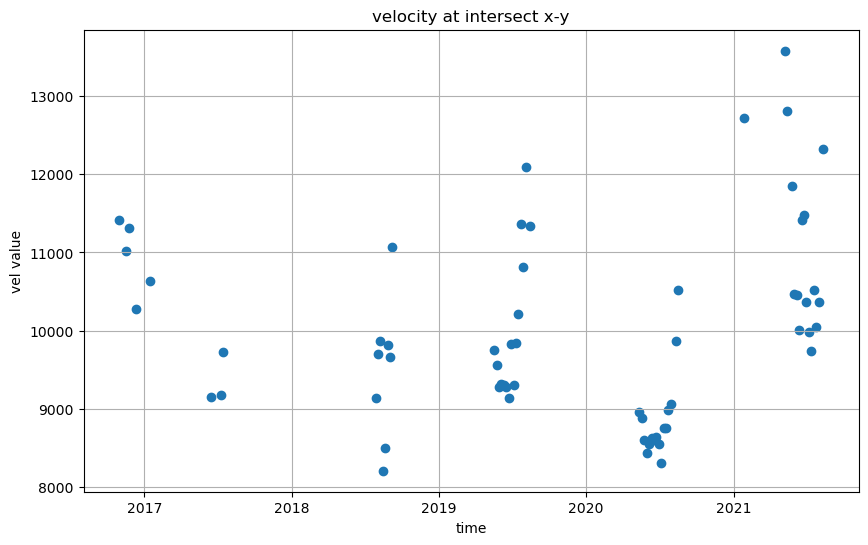

In [11]:
plt.figure(figsize=(10,6))
plt.scatter(terminus["Date"], terminus["velocity_intersection"])
plt.xlabel("time")
plt.ylabel("vel value")
plt.title("velocity at intersect x-y")
plt.grid(True)
plt.show()

In [12]:
#buffer

buffer_m = 1000  #taryn said 1000m 
terminus_buffer = terminus.geometry.buffer(buffer_m)

terminus["buffer"] = terminus_buffer

vel_band = velocity["VelocityMap"].isel(band=2)

velocity_buffer = []

for i in range(len(terminus)):
    buff = terminus["buffer"].iloc[i]
    



In [13]:
#buffer
#Try creating a buffer around the terminus (shapely can do this) and find the centerline intersection with that instead.

from shapely.geometry import Point, MultiPoint, LineString
buffer_m = 1000  #taryn said 1000m 

buffer_intersect_points = []

for i, term_line in enumerate(terminus.geometry):
    if term_line is None:
        buffer_intersect_points.append(None)
        continue
    
    buf = term_line.buffer(buffer_m) #make terminus line fat 1000m
    
    intersect = centreline_shape.intersection(buf) #interesect buf w centreline 
    
    if intersect.is_empty:
        buffer_intersect_points.append(None)
    
    elif isinstance(intersect, Point): #single point intersect 
        buffer_intersect_points.append(intersect)
    
    elif isinstance(intersect, MultiPoint): # if multiple point intersect put the point closes to the oringinal terminus line 
        pts = list(intersect)
        best = min(pts, key=lambda p: p.distance(term_line))
        buffer_intersect_points.append(best)
    
    elif isinstance(intersect, LineString):
        p_mid = intersect.interpolate(0.5, normalized=True)
        buffer_intersect_points.append(p_mid)
    
    else:
        buffer_intersect_points.append(None)

terminus["buffer_intersect_points"] = buffer_intersect_points

In [14]:
vel_band = velocity["VelocityMap"].isel(band=2)  # speed band

vel_buffer_pts = []

for i in range(len(terminus)):
    pt = terminus["buffer_intersect_points"].iloc[i]
    
    if pt is None or pd.isna(pt):
        vel_buffer_pts.append(np.nan)
        continue
    
    v = vel_band.isel(time=i).sel(
        x=pt.x,
        y=pt.y,
        method="nearest",
    ).values
    
    vel_buffer_pts.append(float(v))

terminus["velocity_buffer_pt"] = vel_buffer_pts


In [15]:
terminus

,Image_ID,Image_Tile,Date,Quality_Fl,Glacier_ID,geometry,intersect_points,velocity_intersection,buffer,buffer_intersect_points,velocity_buffer_pt
0,SEN1_NSIDC_0723_V2_20160201_20160212,S1A_090_009787,2016-02-03,0,3,"LINESTRING (-184523.658 -2277242.523, -184005....",POINT (-182041.25466858875 -2275501.966626903),NaN,"POLYGON ((-187170.376 -2265330.752, -187445.75...",POINT (-182257.6866245134 -2275292.98633286),NaN
1,SEN1_NSIDC_0723_V2_20170201_20170206,S1B_090_004141,2017-02-03,1,3,"LINESTRING (-185836.057 -2276614.059, -185698....",None,NaN,"POLYGON ((-187396.433 -2268317.283, -187607.67...",POINT (-183310.1411313571 -2274498.403236279),NaN
2,SEN1_NSIDC_0723_V2_20190215_20190220,S1B_090_014991,2019-02-17,1,3,"LINESTRING (-185915.432 -2276582.309, -185957....",None,NaN,"POLYGON ((-188247.339 -2265873.778, -188120.60...",None,NaN
3,SEN1_NSIDC_0723_V2_20150101_20150112,S1A_090_004012,2015-01-03,0,3,"LINESTRING (-188606.112 -2265922.891, -188399....",POINT (-182302.33390831872 -2275255.0299488134),NaN,"POLYGON ((-189306.988 -2265055.099, -189263.69...",POINT (-182388.11269200183 -2275182.1060847165),NaN
4,SEN1_NSIDC_0723_V2_20150113_20150124,S1A_090_004187,2015-01-15,1,3,"LINESTRING (-188634.464 -2265910.404, -188629....",POINT (-182654.5811722098 -2274965.15839306),NaN,"POLYGON ((-189629.49 -2264978.882, -189624.272...",POINT (-182480.64491905228 -2275103.4408570193),NaN
...,...,...,...,...,...,...,...,...,...,...,...
352,SEN1_NSIDC_0723_V4_20211201_20211206,S1B_090_029866,2021-12-03,1,3,"LINESTRING (-185164.014 -2276666.976, -184867....",POINT (-182522.16672362867 -2275069.1314087305),NaN,"POLYGON ((-186269.536 -2271567.172, -186270.88...",POINT (-182528.26744955353 -2275064.341063878),NaN
353,SEN1_NSIDC_0723_V4_20211207_20211212,S1A_090_040937,2021-12-09,1,3,"LINESTRING (-184931.18 -2276910.393, -184380.8...",POINT (-182337.44590745497 -2275225.1798793296),NaN,"POLYGON ((-188690.355 -2265152.386, -188460.66...",POINT (-182424.5919654968 -2275151.0936423796),NaN
354,SEN1_NSIDC_0723_V4_20211213_20211218,S1B_090_030041,2021-12-15,1,3,"LINESTRING (-184793.596 -2276973.893, -184497....",POINT (-182464.42914589713 -2275117.2265134137),NaN,"POLYGON ((-186345.708 -2271375.76, -186360.341...",POINT (-182499.22022296957 -2275087.649272198),NaN
355,SEN1_NSIDC_0723_V4_20211219_20211224,S1A_090_041112,2021-12-21,1,3,"LINESTRING (-184719.513 -2277016.227, -184391....",POINT (-182646.21693120393 -2274971.726070307),NaN,"POLYGON ((-187684.343 -2265880.982, -187696.34...",POINT (-182560.59106550968 -2275038.9602699815),NaN


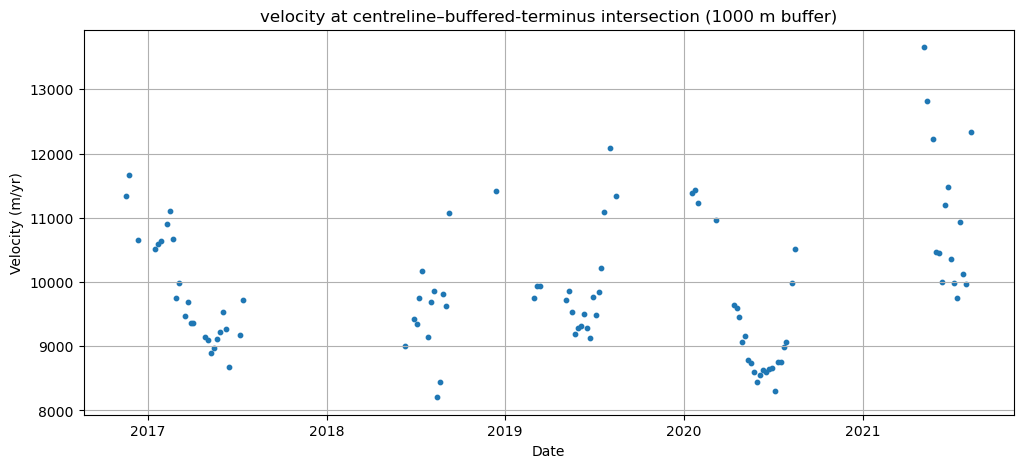

In [16]:
plt.figure(figsize=(12, 5))
plt.scatter(terminus["Date"], terminus["velocity_buffer_pt"], s=10)
plt.xlabel("Date")
plt.ylabel("Velocity (m/yr)")
plt.title("velocity at centreline–buffered-terminus intersection (1000 m buffer)")
plt.grid(True)
plt.show()


In [17]:

centreline_maqit = pd.read_csv(centreline_maqit_path, skiprows=1)


centreline_maqit["Date"] = pd.to_datetime(
    dict(Year=centreline_maqit["Year"],
        Month=centreline_maqit["Month"],
        Day=centreline_maqit["Day"])
)

cl = centreline_maqit[[
    "Date",
    "Terminus Position on flowline",
    "Terminus change (m)"
]]

cl = cl.rename(columns = {
    "Terminus Position on flowline": "L", 
    "Terminus change (m)": "del_L"
})

cl

#merge to terminus set

terminus = terminus.merge(cl)
terminus = terminus.sort_values("Date").reset_index(drop=True)


In [18]:
#dt calc
terminus["dt_days"] = terminus["Date"].diff().dt.days
terminus["dt_years"] = terminus["dt_days"] / 365.25

#dt calc
terminus["dL"] = terminus["L"].diff()
terminus["dLdt"] = terminus["dL"] / terminus["dt_years"]

In [19]:
terminus["calving"] = terminus["velocity_buffer_pt"] - terminus["dLdt"]

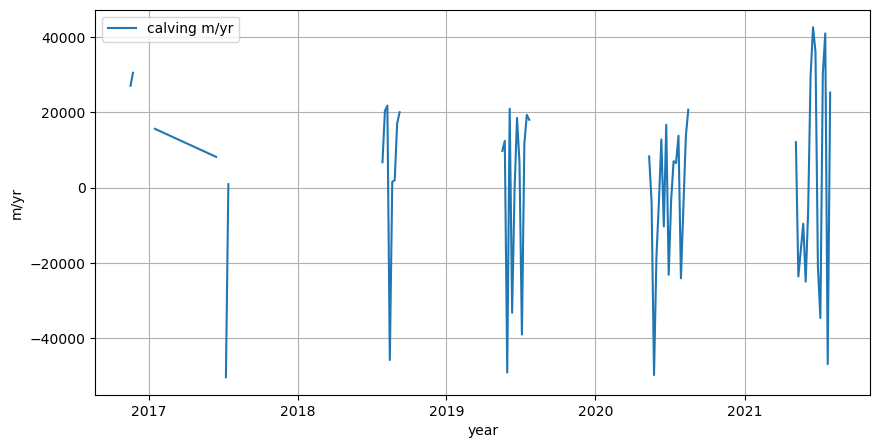

In [31]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot(terminus["Date"], terminus["calving"],  label = "calving m/yr" )

ax.set_xlabel("year")
ax.set_ylabel("m/yr")
ax.grid(True)
ax.legend()
plt.show()


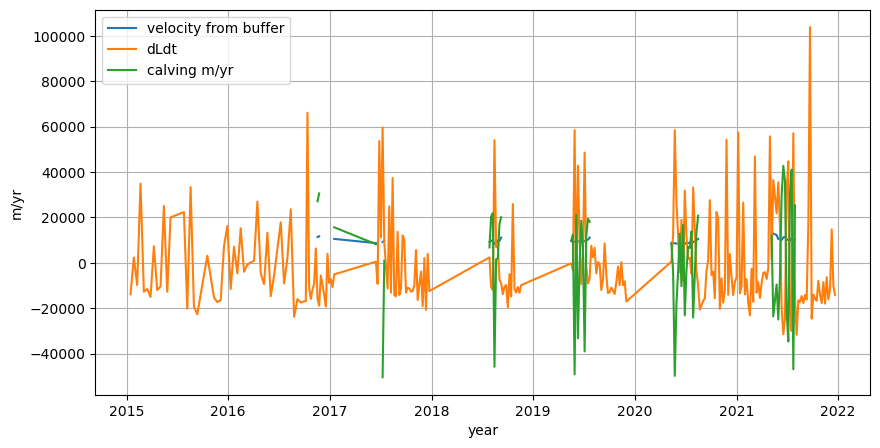

In [30]:

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(terminus["Date"], terminus["velocity_buffer_pt"], label = "velocity from buffer" )
ax.plot(terminus["Date"], terminus["dLdt"], label = "dLdt")
ax.plot(terminus["Date"], terminus["calving"],  label = "calving m/yr" )

ax.set_xlabel("year")
ax.set_ylabel("m/yr")
ax.grid(True)
ax.legend()
plt.show()


In [ ]:
#this is was original attempt using u = 1500 m/yr

In [5]:
#change to date time (this is a thing)
terminus["Date"] = pd.to_datetime(
    dict(year = terminus["Year"],
        month = terminus["Month"],
        day = terminus["Day"])
)

terminus = terminus.rename(columns = {
    "Terminus Position on flowline": "L",
    "Terminus change (m)": "del_L"
})

#for simplicity i just want these (for now, tbd)
terminus_columns = ["Date", "L", "del_L"]
terminus = terminus[terminus_columns].sort_values("Date").reset_index(drop= True)


In [ ]:
#terminus df 
df = terminus.copy().sort_values("Date").reset_index(drop=True)

#dt calc
df["dt_days"] = df["Date"].diff().dt.days
df["dt_years"] = df["dt_days"] / 365.25

#dt calc
df["dL"] = df["L"].diff()
df["dLdt_per_year"] = df["dL"] / df["dt_years"]

df[["Date", "L", "dt_days", "dL", "dLdt_per_year"]].head(10)

#dLdt = dL ( 6 days) - terminus change between data / dt (per year)



,Date,L,dt_days,dL,dLdt_per_year
0,2015-01-03,1492.80,NaN,NaN,NaN
1,2015-01-15,1036.50,12.0,-456.30,-13888.631250
2,2015-01-27,1112.70,12.0,76.20,2319.337500
3,2015-02-08,790.49,12.0,-322.21,-9807.266875
4,2015-02-20,1937.40,12.0,1146.91,34909.073125
5,2015-03-04,1518.00,12.0,-419.40,-12765.487500
6,2015-03-16,1139.70,12.0,-378.30,-11514.506250
7,2015-03-28,645.19,12.0,-494.51,-15051.648125
8,2015-04-09,884.89,12.0,239.70,7295.868750
9,2015-04-21,489.40,12.0,-395.49,-12037.726875


In [8]:
#so w my velocity i should pick a point on the terminus right 
# - probably where it intersects the centreline

centreline.length

0    564300.353452
dtype: float64

In [10]:
vv = velocity["VelocityMap"].sel(band="vv")
print("min, max:", float(vv.min()), float(vv.max()))

min, max: 0.006762796081602573 16439.25


In [11]:
xmin, xmax = float(vv.x.min()), float(vv.x.max())
ymin, ymax = float(vv.y.min()), float(vv.y.max())
print(xmin, xmax, ymin, ymax)

-194000.0 -170000.0 -2288000.0 -2264000.0


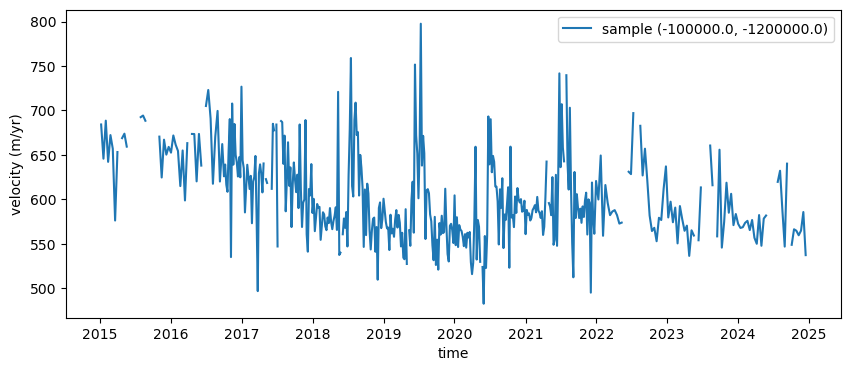

In [12]:
x0 = -100000.0
y0 = -1200000.0

label = 'sample'

vv_band = velocity["VelocityMap"].sel(band='vv')

vel_sample_pt = vv_band.sel(x=x0, y=y0, method='nearest')
df_selected_point = vel_sample_pt.to_dataframe().reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_selected_point['time'], df_selected_point['VelocityMap'], label=f'{label} ({x0}, {y0})')
plt.xlabel('time')
plt.ylabel('velocity (m/yr)')
plt.legend()
plt.show()

#should clean this? claire has a notebook on this 
#should also find a way to pick a point near the terminsu 
# no needto interpooalte

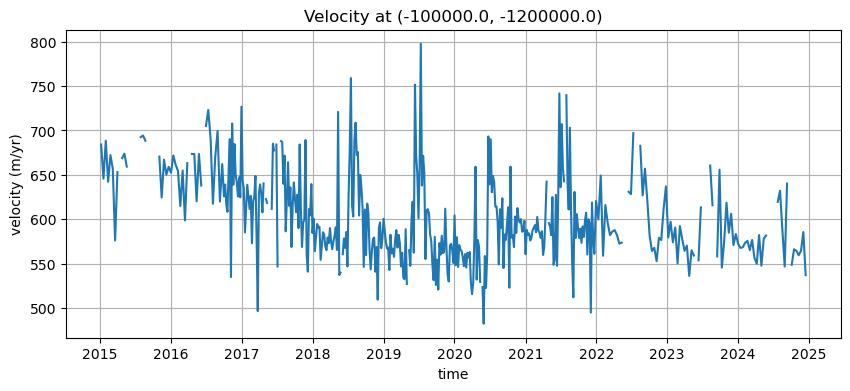

In [21]:

#random upstream point 
sample1 = vv.sel(x=-170000, y=-2200000, method="nearest")  # DataArray with time dim
df_sample = sample1.to_dataframe().reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_sample["time"], df_sample["VelocityMap"])
plt.xlabel("time")
plt.ylabel("velocity (m/yr)")
plt.title(f"Velocity at ({x0}, {y0})")
plt.grid()
plt.show()



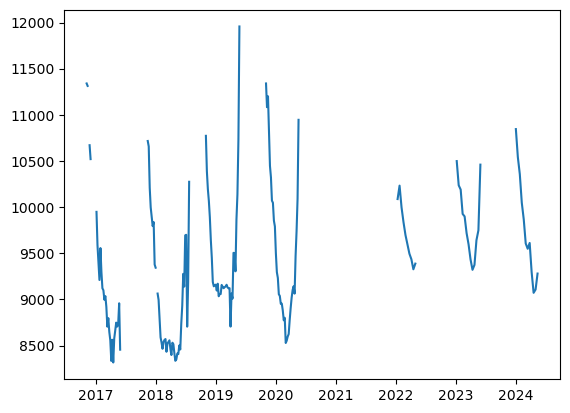

In [23]:
#at date = 1
x_pt = df.loc[0, "x"]
y_pt = df.loc[0, "y"]

vel_pt = vv.sel(x=x_pt, y=y_pt, method="nearest")
df_vel = vel_pt.to_dataframe().reset_index()
plt.plot(df_vel["time"], df_vel["VelocityMap"])

In [24]:
u_vals = []       # velocity at intersection (m/yr)

for _, row in df.iterrows():
    x = row["x"]
    y = row["y"]
    t = row["Date"]

    if pd.isna(x) or pd.isna(y) or pd.isna(t):
        u_vals.append(np.nan)
        continue

    v_intersect = vv.sel(time=t, x=x, y=y, method="nearest").values

    if np.isnan(v_intersect):
        u_vals.append(np.nan)
    else:
        u_vals.append(float(v_intersect))


df["u_per_yr"] = u_vals

In [ ]:
# assuming a veloicty of 1500 m/a to begin the calving series

u_constant = 1500.0 #unit is m /year 

df["u_per_year"] = u_constant


,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y,u_m_per_yr,calving_m_per_yr,u_per_year,calving,vel_date,vel_dt_days
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06,NaN,NaN,1500.0,NaN,2015-01-06 12:00:00,3.5
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06,NaN,NaN,1500.0,15388.631250,2015-01-18 12:00:00,3.5
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06,NaN,NaN,1500.0,-819.337500,2015-01-30 12:00:00,3.5
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06,NaN,NaN,1500.0,11307.266875,2015-02-11 12:00:00,3.5
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06,NaN,NaN,1500.0,-33409.073125,2015-02-23 12:00:00,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,-182377.541027,-2.275191e+06,NaN,NaN,1500.0,17601.437500,2021-11-27 12:00:00,0.5
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,-182522.167388,-2.275069e+06,NaN,NaN,1500.0,13017.550000,2021-12-03 12:00:00,0.5
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-182337.465762,-2.275225e+06,NaN,NaN,1500.0,-13219.575000,2021-12-09 12:00:00,0.5
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,-182464.396164,-2.275117e+06,NaN,NaN,1500.0,11641.775000,2021-12-15 12:00:00,0.5


In [96]:
df["calving"] = df["u_per_year"] - df["dLdt_per_year"]

#calving unit is m /yr
# calving rate > 0 : terminus advance  (due to velocity)
# calving rate < 0 : terminus retreat (due to calving)

In [29]:
df

,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y,u_m_per_yr,calving_m_per_yr,u_per_year,calving
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06,NaN,NaN,1500.0,NaN
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06,NaN,NaN,1500.0,15388.631250
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06,NaN,NaN,1500.0,-819.337500
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06,NaN,NaN,1500.0,11307.266875
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06,NaN,NaN,1500.0,-33409.073125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,-182377.541027,-2.275191e+06,NaN,NaN,1500.0,17601.437500
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,-182522.167388,-2.275069e+06,NaN,NaN,1500.0,13017.550000
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-182337.465762,-2.275225e+06,NaN,NaN,1500.0,-13219.575000
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,-182464.396164,-2.275117e+06,NaN,NaN,1500.0,11641.775000


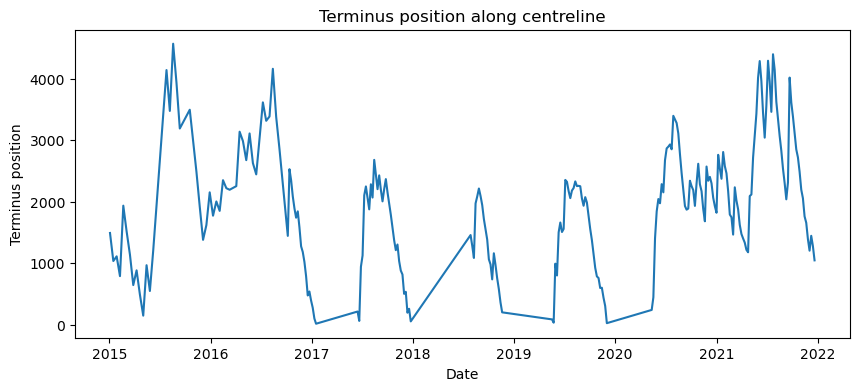

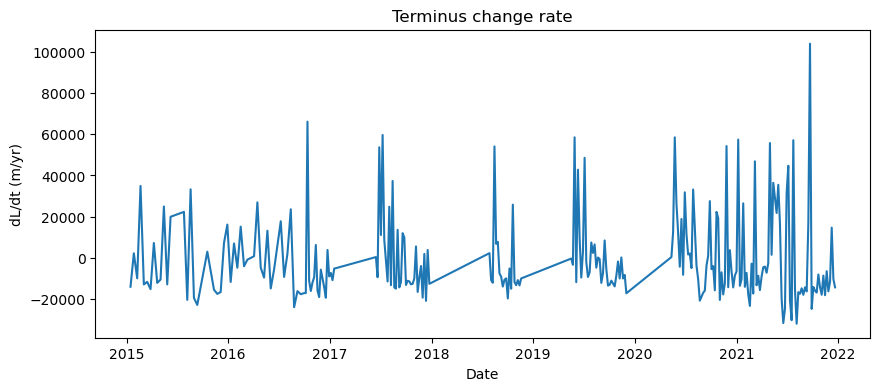

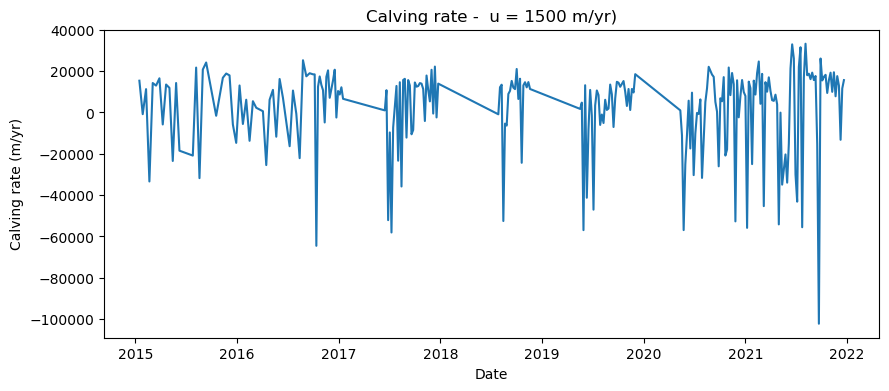

In [97]:

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["L"])
plt.xlabel("Date")
plt.ylabel("Terminus position")
plt.title("Terminus position along centreline")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["dLdt_per_year"])
plt.xlabel("Date")
plt.ylabel("dL/dt (m/yr)")
plt.title("Terminus change rate")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["calving"])
plt.xlabel("Date")
plt.ylabel("Calving rate (m/yr)")
plt.title("Calving rate -  u = 1500 m/yr)")
plt.show()